# Part 1 – Problem Framing 
**1️. What is the real business problem?**

**Answer:**

The core business problem is not insufficient pipeline generation, but declining sales effectiveness. Despite a healthy pipeline volume, fewer deals are converting into wins, indicating issues in deal quality, sales execution, or late-stage deal risk. The CRO lacks visibility into where and why deals are failing and needs data-driven guidance to prioritize actions that improve revenue outcomes.

**2️. What key questions should an AI system answer for the CRO?**

**Answer:**

- Where in the sales pipeline is the win rate declining?

- Which deals are most at risk of being lost right now?

- Are specific sales reps, regions, industries, or product types underperforming?

- Are losses happening early due to poor deal quality or late due to pricing and competition?

- What actions would most improve win rate and revenue in the next quarter?

**3️.What metrics matter most for diagnosing win rate issues?**

**Answer:**

The most important metrics are those that show where and why deals are failing in the sales process. These include:

- Win rate, overall and by key segments such as product type, region, and lead source.

- Stage conversion rates, to identify which sales stages have the highest drop-offs.

- Late-stage loss rate, since losses near closing have the biggest impact on revenue.

- Sales cycle length, to detect deals that take too long and are more likely to fail.

- Sales rep win rate, to understand differences in performance across the sales team.

**4️. What assumptions are you making?**

**Answer:**

- The CRM data correctly represents deal stages and final outcomes after basic cleaning.

- Deals marked as won or lost are labeled accurately.

- Sales patterns observed in recent quarters are stable enough to analyze short-term trends.

- Deal amount and sales cycle duration reasonably reflect deal complexity and sales effort.

- Past sales data provides useful signals for understanding current performance.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
df = pd.read_csv("sales_data.csv")
df.head()


,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [67]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB


In [68]:
# Convert dates
df["created_date"] = pd.to_datetime(df["created_date"])
df["closed_date"] = pd.to_datetime(df["closed_date"])


In [69]:
df.isnull().sum()


deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

In [70]:
df.duplicated().sum()


np.int64(0)

In [71]:
df.groupby(["deal_stage", "outcome"]).size()


deal_stage   outcome
Closed       Lost       531
             Won        466
Demo         Lost       565
             Won        478
Negotiation  Lost       531
             Won        464
Proposal     Lost       558
             Won        451
Qualified    Lost       552
             Won        404
dtype: int64

In [72]:
# Fixes business logic violation
df.loc[df["outcome"].isin(["Won", "Lost"]), "deal_stage"] = "Closed"




In [73]:
df.groupby(["deal_stage", "outcome"]).size()

deal_stage  outcome
Closed      Lost       2737
            Won        2263
dtype: int64

In [74]:
df.describe()


,created_date,closed_date,deal_amount,sales_cycle_days
count,5000,5000,5000.000000,5000.000000
mean,2023-08-14 06:10:56.640000,2023-10-17 00:13:32.160000,26286.492800,63.751800
min,2023-01-01 00:00:00,2023-01-11 00:00:00,2002.000000,7.000000
25%,2023-04-22 00:00:00,2023-06-26 00:00:00,6611.000000,35.750000
50%,2023-08-14 00:00:00,2023-10-15 00:00:00,14171.500000,64.000000
75%,2023-12-06 00:00:00,2024-02-08 00:00:00,39062.250000,92.000000
max,2024-03-26 00:00:00,2024-07-20 00:00:00,100000.000000,120.000000
std,NaN,NaN,27689.230136,32.731405


In [75]:
(df["closed_date"] >= df["created_date"]).all()


np.True_

In [76]:
print("Invalid deal_amount rows:", (df["deal_amount"] <= 0).sum())
print("Invalid sales_cycle rows:", (df["sales_cycle_days"] < 0).sum())


Invalid deal_amount rows: 0
Invalid sales_cycle rows: 0


In [77]:
df = df[df["deal_amount"] > 0]
df = df[df["sales_cycle_days"] >= 0]


In [78]:
for col in ["industry", "region", "product_type", "lead_source", "outcome"]:
    print(col, df[col].unique())


industry ['SaaS' 'HealthTech' 'FinTech' 'EdTech' 'Ecommerce']
region ['North America' 'India' 'APAC' 'Europe']
product_type ['Enterprise' 'Core' 'Pro']
lead_source ['Referral' 'Inbound' 'Partner' 'Outbound']
outcome ['Won' 'Lost']


In [79]:
# Standardize text columns
text_cols = ["industry", "region", "product_type", "lead_source", "deal_stage", "outcome"]
for col in text_cols:
    df[col] = df[col].str.strip().str.title()


In [80]:
# Creating helpful features
df["quarter"] = df["closed_date"].dt.to_period("Q")
df["is_won"] = (df["outcome"] == "Won").astype(int)


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   deal_id           5000 non-null   object        
 1   created_date      5000 non-null   datetime64[ns]
 2   closed_date       5000 non-null   datetime64[ns]
 3   sales_rep_id      5000 non-null   object        
 4   industry          5000 non-null   object        
 5   region            5000 non-null   object        
 6   product_type      5000 non-null   object        
 7   lead_source       5000 non-null   object        
 8   deal_stage        5000 non-null   object        
 9   deal_amount       5000 non-null   int64         
 10  sales_cycle_days  5000 non-null   int64         
 11  outcome           5000 non-null   object        
 12  quarter           5000 non-null   period[Q-DEC] 
 13  is_won            5000 non-null   int64         
dtypes: datetime64[ns](2), in

In [82]:
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,quarter,is_won
0,D00001,2023-11-24,2023-12-15,rep_22,Saas,North America,Enterprise,Referral,Closed,4253,21,Won,2023Q4,1
1,D00002,2023-01-17,2023-01-27,rep_7,Saas,India,Core,Referral,Closed,3905,10,Won,2023Q1,1
2,D00003,2023-10-29,2023-12-10,rep_5,Healthtech,Apac,Core,Inbound,Closed,10615,42,Lost,2023Q4,0
3,D00004,2023-07-14,2023-08-02,rep_18,Fintech,India,Core,Partner,Closed,4817,19,Won,2023Q3,1
4,D00005,2024-02-29,2024-05-26,rep_2,Healthtech,Apac,Core,Outbound,Closed,45203,87,Lost,2024Q2,0


# Part 2 – Data Exploration & Insights

## Insight 1: Win rate is lower than expected
- Insight (What is happening?)

The overall win rate is around 45%, meaning more deals are being lost than won.

- Why does it matter?

A lower win rate directly impacts revenue growth. Even with a healthy pipeline, losing more than half the deals makes revenue unpredictable and increases pressure on sales teams to generate more deals.

- What action could it drive?

Since many deals already exist, the focus should be on making existing deals better and closing them more effectively, rather than adding more low-quality deals.”

In [83]:
df.shape

(5000, 14)

In [84]:
df["outcome"].value_counts(normalize=True)


outcome
Lost    0.5474
Won     0.4526
Name: proportion, dtype: float64

## Insight 2: Win Rate Fluctuates across quarters

**What is happening?**
- Win rate fluctuates across quarters, with some periods showing clear drops followed by recoveries.

**Why does it matter?**
- Win rate directly impacts revenue. Even with a healthy pipeline, inconsistent conversion makes revenue forecasting unreliable and indicates unstable sales performance.

**What action could it drive?**
- Look at quarters where win rate was low to see what went wrong, copy what worked in high-performing quarters, and train sales teams early so win rate doesn’t drop again.

In [85]:
df.groupby("quarter")["is_won"].mean()


quarter
2023Q1    0.445122
2023Q2    0.450154
2023Q3    0.428150
2023Q4    0.475170
2024Q1    0.466667
2024Q2    0.437991
2024Q3    0.517241
Freq: Q-DEC, Name: is_won, dtype: float64

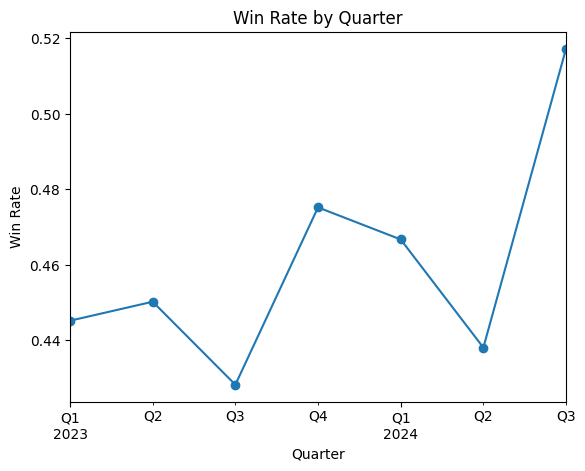

In [86]:
ax = df.groupby("quarter")["is_won"].mean().plot(
    kind="line",
    marker="o",
    title="Win Rate by Quarter"
)

ax.set_xlabel("Quarter")
ax.set_ylabel("Win Rate")

plt.show()


## Insight 3:Enterprise deals have a slightly lower win rate compared to Core and Pro deals
**What is happening?**
- Enterprise deals have a slightly lower win rate compared to Core and Pro deals.

**Why does it matter?**
- Even though enterprise deals do not have much higher deal amounts in this dataset, they appear to be more complex and harder to close. Their lower win rate can still pull down the overall win rate, even when the pipeline looks healthy.

**What action could it drive?**
- Focus on better qualification and stronger sales support for enterprise deals, involve experienced sales leaders early, and train teams to manage complex, multi-stakeholder sales more effectively.

In [87]:
# Calculate win rate by product type
df.groupby("product_type")["is_won"].mean().sort_values()



product_type
Enterprise    0.449693
Pro           0.452864
Core          0.455136
Name: is_won, dtype: float64

In [88]:
df.groupby("product_type")["deal_amount"].mean().sort_values()


product_type
Enterprise    25705.325767
Core          26436.738489
Pro           26699.849642
Name: deal_amount, dtype: float64

## Insight 4: Inbound and Referral have higher win rates

**What is happening?**
- Inbound and referral leads have higher win rates, while partner leads convert the least.

**Why does it matter?**
- Lead quality varies by source. Low-converting channels reduce sales efficiency and can hurt overall win rate even when the pipeline looks healthy.

**What action could it drive?**
- Focus sales effort on inbound and referral leads, strengthen qualification for partner leads, and optimize outbound targeting to improve lead quality.

In [89]:
df.groupby("lead_source")["is_won"].mean().sort_values()




lead_source
Partner     0.439516
Outbound    0.455056
Referral    0.455272
Inbound     0.460380
Name: is_won, dtype: float64

## Custom Metrics

In [90]:
# Custom Metric 1: Pipeline Efficiency Score

pipeline_efficiency = (
    df[df["outcome"] == "Won"]["deal_amount"].sum()
    / df["deal_amount"].sum()
)
pipeline_efficiency

np.float64(0.46099172271471683)

## Simple explanation
- Pipeline efficiency shows that only about 46% of total pipeline value converts into revenue, indicating significant inefficiency in deal conversion despite a healthy pipeline.”

In [91]:
# Custom Metric 2 : Deal Velocity Score (DVS)
df["deal_velocity_score"] = df["deal_amount"] / df["sales_cycle_days"]


In [92]:
df[["deal_amount", "sales_cycle_days", "deal_velocity_score"]].head()


,deal_amount,sales_cycle_days,deal_velocity_score
0,4253,21,202.523810
1,3905,10,390.500000
2,10615,42,252.738095
3,4817,19,253.526316
4,45203,87,519.574713


In [93]:

df.sort_values("deal_velocity_score", ascending=False).head(10)

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome,quarter,is_won,deal_velocity_score
81,D00082,2024-02-25,2024-03-03,rep_5,Ecommerce,India,Pro,Partner,Closed,96011,7,Won,2024Q1,1,13715.857143
2640,D02641,2024-02-12,2024-02-19,rep_18,Saas,India,Pro,Partner,Closed,94892,7,Won,2024Q1,1,13556.000000
2016,D02017,2023-05-13,2023-05-20,rep_16,Healthtech,India,Enterprise,Inbound,Closed,88790,7,Won,2023Q2,1,12684.285714
1906,D01907,2023-10-23,2023-10-31,rep_4,Ecommerce,India,Enterprise,Inbound,Closed,95085,8,Lost,2023Q4,0,11885.625000
1686,D01687,2024-02-06,2024-02-14,rep_21,Saas,North America,Pro,Referral,Closed,93142,8,Lost,2024Q1,0,11642.750000
4806,D04807,2023-06-20,2023-06-27,rep_15,Ecommerce,North America,Core,Inbound,Closed,80995,7,Won,2023Q2,1,11570.714286
255,D00256,2023-10-25,2023-11-01,rep_3,Saas,India,Core,Referral,Closed,80089,7,Lost,2023Q4,0,11441.285714
4423,D04424,2023-09-12,2023-09-19,rep_25,Fintech,Europe,Pro,Inbound,Closed,80056,7,Lost,2023Q3,0,11436.571429
2238,D02239,2023-06-22,2023-06-30,rep_13,Saas,North America,Enterprise,Partner,Closed,87321,8,Lost,2023Q2,0,10915.125000
3117,D03118,2023-08-12,2023-08-19,rep_25,Fintech,North America,Enterprise,Partner,Closed,75486,7,Lost,2023Q3,0,10783.714286


## Simple explanation 

- Deal Velocity Score measures revenue generated per day of the sales cycle, helping identify deals that are moving slowly relative to their size.”

# Part 3 – Build a Decision Engine



## Build a simple model / rule-based system
Modeling choice (intentionally simple)

Instead of a complex ML model, we use a rule-based risk score that combines two strong risk signals:

Sales cycle length → long-running deals are more likely to stall

Deal amount → larger deals have more approvals

## Option A – Deal Risk Scoring

## Define the Problem

The CRO observes that win rate is declining despite a healthy pipeline. Sales teams are working many deals, but leadership lacks visibility into which deals are most at risk of failing.

The objective is to build a simple, interpretable system that identifies high-risk deals early and enables proactive intervention.

## Risk Model Construction
Deal Risk Index (DRI)

We define risk based on two core signals:

Sales cycle length → Longer deals are more likely to stall.

Deal amount → Larger deals involve more stakeholders and friction.

In [94]:

df["deal_risk_index"] = (
    df["sales_cycle_days"] / df["sales_cycle_days"].max()
) * (
    df["deal_amount"] / df["deal_amount"].max()
)





In [95]:
df[["sales_cycle_days", "deal_amount", "deal_risk_index"]].head()


,sales_cycle_days,deal_amount,deal_risk_index
0,21,4253,0.007443
1,10,3905,0.003254
2,42,10615,0.037152
3,19,4817,0.007627
4,87,45203,0.327722


## How to interpret the output
Risk Index	What it means

- 0.003 – 0.01	Very small & fast deals → almost no risk

- 0.03 – 0.07	Medium deals → low risk

- 0.32	Big & slow deal → high risk

## Why this works:

- Normalization ensures both features are scaled between 0 and 1.

- Multiplication ensures a deal is flagged only if it is both large and slow.

- Output is intuitive:

- 0 → low risk

- 1 → highest relative risk

## Generate actionable outputs
Convert risk score into clear categories

In [96]:
# A deal is risky only if it is both big AND slow
df["risk_level"] = pd.qcut(
    df["deal_risk_index"],
    q=3,
    labels=["Low Risk", "Medium Risk", "High Risk"]
)
df["risk_level"].value_counts()

risk_level
Low Risk       1667
High Risk      1667
Medium Risk    1666
Name: count, dtype: int64

## Example output for leadership

- High Risk deals → large, slow-moving, likely to stall

- Medium Risk deals → need closer monitoring

- Low Risk deals → progressing normally

  This turns raw data into clear priorities.

##  How a sales leader would use this

A CRO or Sales Manager can:

- Review High Risk deals weekly

- Assign senior reps or leadership support to critical deals

- Re-qualify deals that are unlikely to close

- Prevent last-minute surprises at quarter end

Example decision:

“These 15 deals account for a large portion of pipeline value and are high risk — let’s focus on fixing these instead of adding more deals.”

# Part 4 – Mini System Design
Design a lightweight Sales Insight & Alert System.

Include:

1.High-level architecture (diagram optional)

2.Data flow

3.Example alerts or insights

4.How often it runs

5.Failure cases and limitations

Think like:
“If SkyGeni were to productize this, what would it look like?”


## Lightweight Sales Insight & Alert System
**System Goal**

Design a lightweight system that:

Continuously analyzes CRM data, detects risk patterns, and proactively alerts sales leaders about revenue threats and optimization opportunities.


**1.High-Level Architecture – Sales Insight & Alert System**

1. **CRM (Salesforce / HubSpot)**  
   Source of deal and sales activity data.

2. **Data Ingestion Layer (Daily Pull)**  
   Automated pipeline that extracts CRM data daily.

3. **Data Processing & Feature Engine**  
   Cleans data and computes metrics such as Deal Risk Index and Deal Velocity Score.

4. **Risk & Insight Engine**  
   Applies business rules to classify deals and generate insights.

5. **Alert System + Dashboard**  
   Displays insights and sends automated alerts to stakeholders.

6. **Sales Leader Actions**  
   CROs and Sales Managers prioritize high-risk deals and allocate resources.


**2.Data Flow**

**Step 1: Data Ingestion**

Pull deal data daily from CRM

Fields:
        
- deal_amount
        
- sales_cycle_days
        
- stage
        
- lead_source
        
- product_type
        
- outcome (historical)
 
**Step 2: Feature Engineering**

Compute:

- Deal Risk Index

- Deal Velocity Score

- Risk buckets (Low/Medium/High)

- Pipeline exposure metrics

**Step 3: Insight Engine**

Apply simple rules:

- Flag high-risk large deals

- Detect pipeline concentration risk

- Identify declining win-rate trends

- Identify high-value deals aging beyond threshold

**Step 4: Output Layer**

Two main outputs:

**A) Dashboard View**

- Total pipeline value

- Pipeline value at risk

- Top 10 high-risk deals

- Win rate trend (last 4 quarters)

**B) Alert Engine**

Automated alerts sent via:

- Email

- Slack

- CRM notification

**3.Example Alerts / Insights**

**Alert 1: Revenue at Risk**

“62% of current pipeline value is in high-risk deals.”

**Alert 2: Deal Aging Alert**

“Deal #3421 has been in Negotiation for 95 days and is in the top 10% risk bucket.”

**Alert 3: Win Rate Drop**

“Win rate in Enterprise segment dropped 5% compared to last quarter.”

**Alert 4: Lead Source Weakness**

“Partner-sourced deals have a 3% lower win rate than other channels.”

**4.How Often It Runs**

Recommended cadence:

- Daily ingestion

- Risk recalculation daily

- Alerts triggered in real time or daily digest

- Trend insights generated weekly


**5.Failure Cases & Limitations**


**1. Data Quality Issues**

- If CRM data is inaccurate:

- Incorrect stage updates

- Missing deal amounts

- Inconsistent sales cycle tracking
→ Risk scores may be misleading.

**2. Over-Simplified Risk Logic**

Current risk logic only uses:

- Deal size

- Sales cycle

Other important drivers may include:

- Rep performance

- Customer industry

- Competitive pressure

**3. Alert Fatigue**

- Too many alerts may:

- Reduce trust

- Be ignored by sales teams

System should:

Prioritize high-impact alerts only.

**4. Synthetic Dataset Limitation**

In this dataset:

Risk levels did not strongly predict win rate
So predictive performance is limited.

In production:

Historical training would refine scoring.

# Part 5 – Reflection
**A short reflection:**


**1.What assumptions in your solution are weakest?**

The weakest assumption in my solution is that deal size and sales cycle length alone can explain deal risk. In reality, many other factors affect whether a deal closes, such as the skill of the sales rep, competition, customer urgency, or budget availability. I also assumed that CRM data is always accurate and updated properly, which may not be true in real companies.

**2.What would break in real-world production?**

The system could fail if CRM data is incomplete or not updated regularly by sales reps. If deal stages or sales cycle days are incorrect, the risk score would not be reliable. Too many alerts could also overwhelm the sales team and reduce trust in the system. Additionally, the same logic may not work equally well for all industries or company sizes.

**3.What would you build next if given 1 month?**

If given one month, I would build a simple predictive model to estimate win probability using more features such as deal stage, lead source, and rep performance. I would also test and validate whether the risk score truly predicts losses. Finally, I would add a “Next Best Action” feature to suggest what sales reps should do for each risky deal.

**4.What part of your solution are you least confident about?**

I am least confident about whether the chosen risk thresholds (Low, Medium, High) are optimally defined. Since the buckets were created using equal quantiles, they may not reflect true business risk boundaries. In a real-world setting, risk levels should ideally be based on historical performance patterns or revenue impact rather than evenly split categories.